<a href="https://colab.research.google.com/github/kaoutharSaidi/Adaptive-Intelligent-Tutoring-System-for-Automated-Math-Assessment-/blob/main/Project_NLP_SaadiaKassidi_kaoutharSaidi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Intelligent Tutoring System for Automated Math Assessment and Content Adaptation

## Objective

This project aims to design and implement an **end-to-end adaptive intelligent tutoring system** for mathematics learning.  
The system combines:

- **Automatic student answer assessment** using a fine-tuned **DistilBERT** model  
- **Error-aware evaluation** using edit distance between student and expected answers  
- **Bayesian Knowledge Tracing (BKT)** to model student mastery over time  
- **Content adaptation** to dynamically adjust difficulty, provide remediation, or allow progression  

The final system simulates and supports **personalized learning paths** by continuously estimating student knowledge and adapting instructional decisions in real time.

## Step 1: Data Preprocessing and Feature Engineering

In this step, we prepare the AMMORE student answer dataset for modeling.

The objectives are to:
- Clean raw student responses and expected answers
- Normalize mathematical expressions
- Handle missing values safely
- Engineer similarity-based features such as edit distance
- Create auxiliary features useful for analysis and grading

This step ensures that the data is clean, consistent, and suitable for both
machine learning models and educational analysis.


In [ ]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 44.7 MB/s eta 0:00:0000:0100:01


In [ ]:
import pandas as pd
import re
from Levenshtein import distance as levenshtein_distance
import nltk
from nltk.tokenize import word_tokenize
import logging

# Setup logging
logging.basicConfig(
    filename='adaptive_tutor.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Ensure necessary NLTK resources are available
nltk.download('punkt')

### Text Normalization and Feature Extraction

We define a preprocessing function that:
- Cleans student responses by removing noise and non-mathematical symbols
- Normalizes operators (e.g., × → *)
- Computes **Levenshtein edit distance** to quantify answer correctness
- Detects exact matches
- Measures response length as a proxy for answer complexity


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


   user_id                   original_message_id  text message_inserted_at  \
0        1  ABEGIzUzZzY4AhD0vOuTYq6aX9tCu1tCeN7X   3/4        2/18/24 9:15   
1        1  ABEGIzUzZzY4AhBWTZVgulowqPaWMJTTSD5T   1/1        2/18/24 9:18   
2        1  ABEGIzUzZzY4AhCW1MO62MX_j8TCIcSJCPol   2/1        2/18/24 9:18   
3        1  ABEGIzUzZzY4AhD-VUtpq-xGynD5yP3lxvdR   2/2        2/18/24 9:18   
4        1  ABEGIzUzZzY4AhDJYqV9Vue7sS2rpXUOwFdA  4/12        2/18/24 9:12   

                                          question expected_answer  \
0    Find the reciprocal of the given fraction. 12            1/12   
1   Find the reciprocal of the given fraction. 1/2               2   
2   Find the reciprocal of the given fraction. 1/2               2   
3   Find the reciprocal of the given fraction. 4/4               1   
4  Find the reciprocal of the given fraction. 12/4             1/3   

   question_level question_micro_lesson       question_skill question_topic  \
0               6          G6.N

/tmp/ipykernel_55/2747853391.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=processed_data, x='human_label', order=label_order, palette='viridis')
/tmp/ipykernel_55/2747853391.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=processed_data, x='human_label', y='response_word_count', palette='Set2')


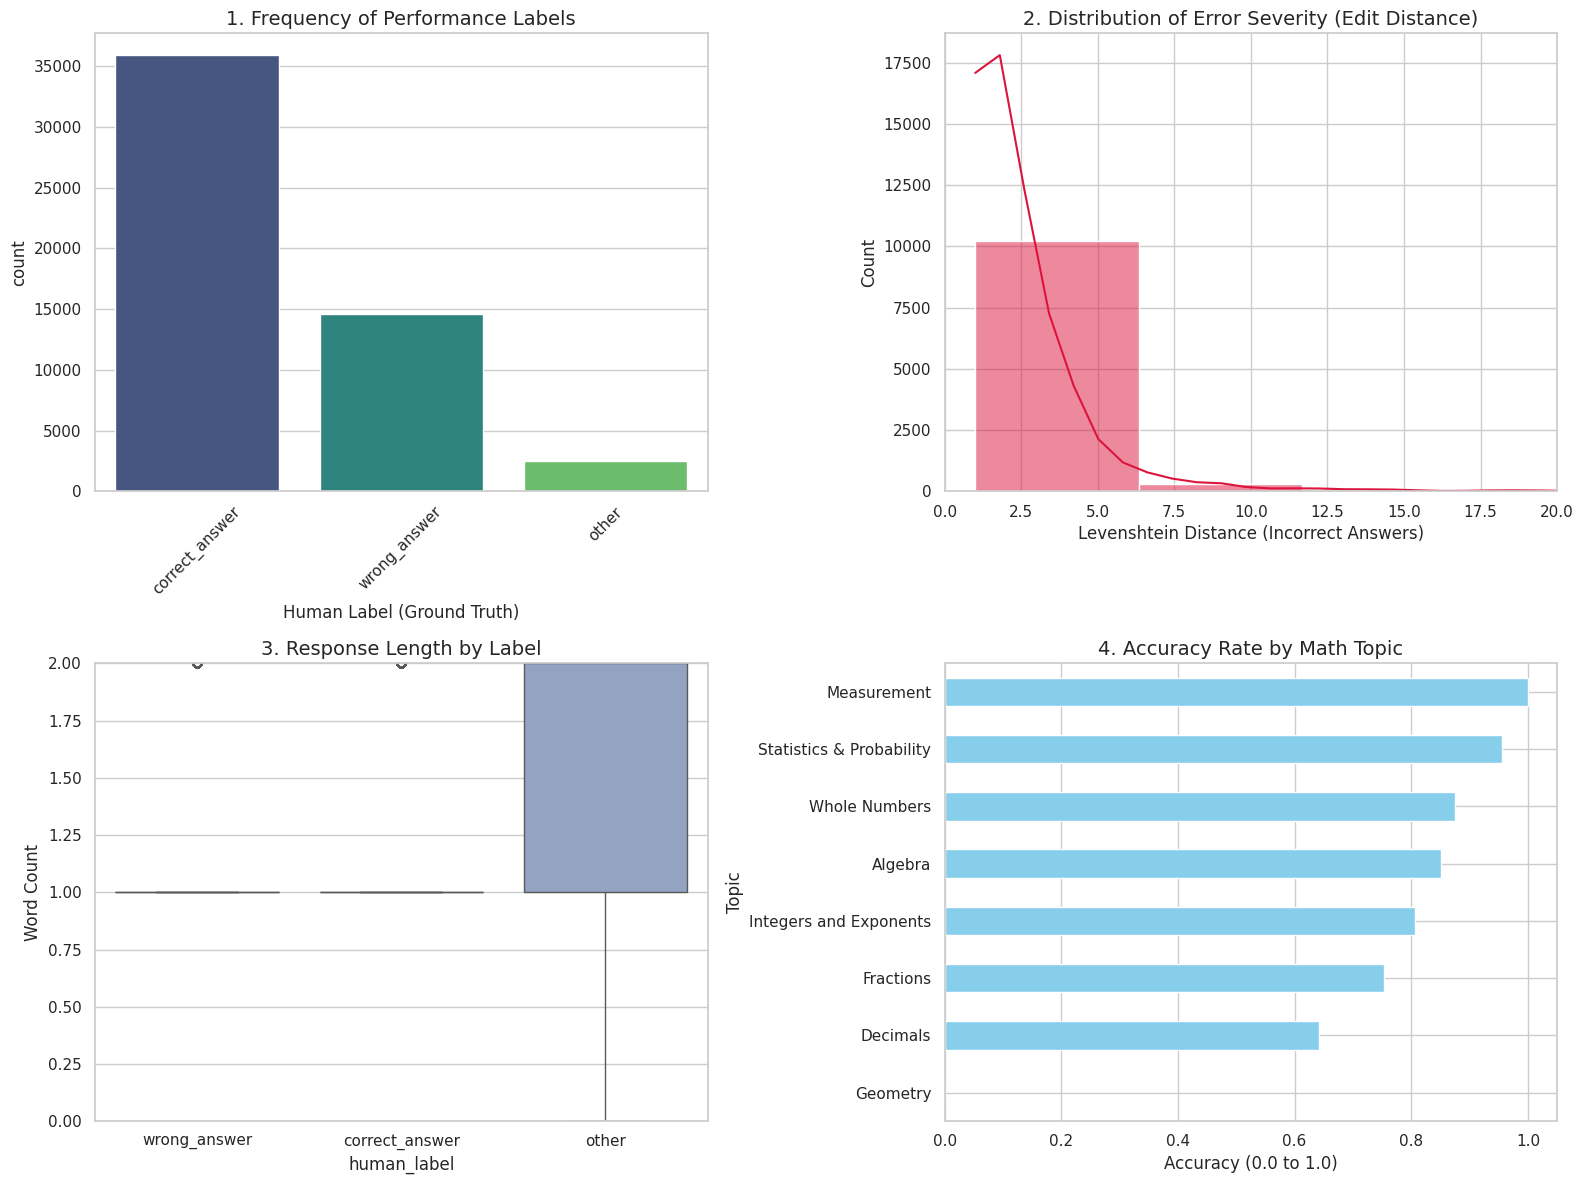

In [ ]:
def preprocess_ammore_data(df):
    """
    Cleans student responses and extracts features based on the
    AMMORE dataset structure. Handles missing values and ensures
    data types are compatible with Transformer models.
    """

    # 1. Create a copy to avoid 'SettingWithCopy' warnings in Pandas
    df = df.copy()

    # 2. Defensive Data Cleaning: Handle NaNs and force string types
    df['text'] = df['text'].fillna("").astype(str)
    df['question'] = df['question'].fillna("").astype(str)
    df['expected_answer'] = df['expected_answer'].fillna("").astype(str)

    # 3. Filter Training Data: Keep only rows where we have a ground truth label
    df = df.dropna(subset=['human_label'])

    def clean_math_text(text):
        """
        Sub-function to normalize mathematical expressions and
        remove chat-related noise.
        """
        # Lowercase and remove leading/trailing whitespace
        text = text.lower().strip()

        # Remove WhatsApp placeholders like <Media omitted> or stickers
        text = re.sub(r'<.*?>', '', text)

        # Normalize math operators so "10 x 2" matches "10 * 2"
        text = text.replace('times', '*').replace('x', '*').replace('÷', '/')

        # Keep only digits, decimals, and basic operators
        text = re.sub(r'[^0-9\+\-\*\/\.\s]', '', text)

        return text.strip()

    # 4. Apply cleaning to create "Canonical" versions of answers
    df['clean_student_response'] = df['text'].apply(clean_math_text)
    df['clean_expected_answer'] = df['expected_answer'].apply(clean_math_text)

    # --- Feature Engineering ---

    # 5. Edit Distance (Levenshtein)
    df['edit_distance'] = df.apply(
        lambda x: levenshtein_distance(x['clean_student_response'], x['clean_expected_answer']),
        axis=1
    )

    # 6. Exact Match Feature: Binary flag for quick filtering
    df['is_exact_match'] = (df['clean_student_response'] == df['clean_expected_answer']).astype(int)

    # 7. Response Length
    df['response_word_count'] = df['text'].apply(lambda x: len(word_tokenize(x)))

    logging.info(f"Preprocessing complete. Dataset size: {len(df)}")
    return df

# Example Usage:
try:
    data = pd.read_csv("/kaggle/input/ammor-codegen/AMMORE_student_answers.csv")
    print(data.head(5))
    processed_data = preprocess_ammore_data(data)

    # --- Grade Discovery Script ---
    unique_levels = processed_data['question_level'].unique()
    unique_levels_sorted = sorted([lvl for lvl in unique_levels if pd.notna(lvl)])

    print("--- 📊 DATASET GRADE ANALYSIS ---")
    print(f"Unique levels found: {unique_levels_sorted}")

    print("\nQuestions per Grade:")
    print(processed_data['question_level'].value_counts().sort_index())

    null_count = processed_data['question_level'].isna().sum()
    if null_count > 0:
        print(f"\n⚠️ WARNING: Found {null_count} questions with NO grade assigned.")

    if 'text' in data.columns:
        print("Preprocessing Complete!")
        print(processed_data[['text', 'clean_student_response', 'expected_answer', 'edit_distance']].head())
    else:
        print("Error: Column 'text' not found. Please check the dataset loading step.")

except Exception as e:
    logging.error(f"Error in preprocessing: {e}")
    print(f"Error loading or processing data: {e}")



## Step 2: Exploratory Data Analysis (EDA)

This section explores the characteristics of student answers and grading labels.

We analyze:
- Distribution of human performance labels
- Severity of errors using edit distance
- Relationship between response length and performance
- Accuracy rates across different math topics

These insights help validate the dataset and guide modeling decisions.


In [ ]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 12))

# --- Plot 1: Distribution of Student Performance ---
plt.subplot(2, 2, 1)
label_order = processed_data['human_label'].value_counts().index
sns.countplot(data=processed_data, x='human_label', order=label_order, palette='viridis')
plt.title('1. Frequency of Performance Labels', fontsize=14)
plt.xticks(rotation=45)
plt.xlabel('Human Label (Ground Truth)')

# --- Plot 2: Distribution of Edit Distance ---
plt.subplot(2, 2, 2)
incorrect_df = processed_data[processed_data['is_exact_match'] == 0]
sns.histplot(incorrect_df['edit_distance'], bins=30, kde=True, color='crimson')
plt.xlim(0, 20)
plt.title('2. Distribution of Error Severity (Edit Distance)', fontsize=14)
plt.xlabel('Levenshtein Distance (Incorrect Answers)')

# --- Plot 3: Response Complexity vs. Performance ---
plt.subplot(2, 2, 3)
sns.boxplot(data=processed_data, x='human_label', y='response_word_count', palette='Set2')
plt.title('3. Response Length by Label', fontsize=14)
plt.ylim(0, processed_data['response_word_count'].quantile(0.95))
plt.ylabel('Word Count')

# --- Plot 4: Skill Difficulty Analysis ---
plt.subplot(2, 2, 4)
skill_difficulty = processed_data.groupby('question_topic')['is_exact_match'].mean().sort_values()
skill_difficulty.plot(kind='barh', color='skyblue')
plt.title('4. Accuracy Rate by Math Topic', fontsize=14)
plt.xlabel('Accuracy (0.0 to 1.0)')
plt.ylabel('Topic')

plt.tight_layout()
plt.savefig('ammore_research_plots.png')
plt.show()

## Step 3: Automated Student Answer Assessment Using DistilBERT

In this step, we fine-tune a **DistilBERT** transformer model to classify
student answers based on their correctness level.

The model uses:
- Student response text
- Corresponding question context
- Human-labeled performance categories

The goal is to automatically approximate expert grading decisions.


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import json
from datetime import datetime
import os

# Initialize the tokenizer first
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# 1. Ensure all inputs are strings and labels are valid integers
processed_data['text'] = processed_data['text'].fillna("").astype(str)
processed_data['question'] = processed_data['question'].fillna("").astype(str)

# 2. Map human labels to numeric IDs for the model
label_names = processed_data['human_label'].unique().tolist()
label_map = {name: i for i, name in enumerate(label_names)}
processed_data['label'] = processed_data['human_label'].map(label_map)

# 3. Create a combined text field for context
full_texts = (processed_data['text'] + " [SEP] " + processed_data['question']).tolist()
labels = processed_data['label'].tolist()





2026-02-06 18:28:45.365911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770402525.556804      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770402525.612179      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770402526.073276      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770402526.073316      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770402526.073319      55 computation_placer.cc:177] computation placer alr

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized and moved to cuda
Training set size: 42424
Validation set size: 10607
Starting training on Kaggle GPU...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.343100,0.316635,0.871311,0.863431
2,0.229200,0.218416,0.926464,0.924802
3,0.169000,0.197963,0.949467,0.948378
4,0.082000,0.180183,0.963326,0.962904
5,0.054100,0.175454,0.968323,0.968022


Model saved to ./distilbert_assessment_model with metadata
Training Complete! Final Metrics: {'eval_loss': 0.17545394599437714, 'eval_accuracy': 0.9683228056943528, 'eval_f1': 0.9680220449086834, 'eval_runtime': 9.0942, 'eval_samples_per_second': 1166.354, 'eval_steps_per_second': 18.253, 'epoch': 5.0}


### Train–Validation Split

To avoid data leakage and ensure fair evaluation:
- The dataset is split into training and validation sets
- Stratification is applied to preserve class distribution


In [ ]:
# 4. **FIXED: Proper Train/Validation Split to prevent data leakage**
train_texts, val_texts, train_labels, val_labels = train_test_split(
    full_texts, labels, test_size=0.2, stratify=labels, random_state=42
)

# 5. Tokenization for both train and validation sets
train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=64)
val_encodings = tokenizer(val_texts, padding="max_length", truncation=True, max_length=64)

# 6. Define Dataset Class
class AmmoreDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 7. Create train and validation datasets
train_dataset = AmmoreDataset(train_encodings, train_labels)
val_dataset = AmmoreDataset(val_encodings, val_labels)

# 8. Define metrics computation function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}

### Model Training Configuration

The training setup includes:
- Cross-entropy loss for multi-class classification
- Weighted F1-score as the primary evaluation metric
- Automatic checkpointing and best-model selection

After training, the model is saved together with:
- Evaluation metrics
- Label mappings
- Model type and timestamp

This ensures reproducibility and traceability for future deployment.

In [ ]:
# 9. Set up Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

# 10. Initialize the Model
num_labels = len(label_map)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)

# 11. Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model initialized and moved to {device}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# 12. Initialize the Trainer with separate validation set
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # **FIXED: Now using separate validation data**
    compute_metrics=compute_metrics
)

# 13. Start Training
print("Starting training on Kaggle GPU...")
try:
    trainer.train()

    # 14. **NEW: Save model with metadata**
    def save_model_with_metadata(model, tokenizer, path, metrics, label_map):
        os.makedirs(path, exist_ok=True)
        model.save_pretrained(path)
        tokenizer.save_pretrained(path)

        metadata = {
            'timestamp': datetime.now().isoformat(),
            'metrics': metrics,
            'num_labels': model.config.num_labels,
            'label_map': label_map,
            'model_type': 'DistilBERT'
        }

        with open(f"{path}/metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)

        print(f"Model saved to {path} with metadata")

    # Get final metrics
    eval_results = trainer.evaluate()

    # Save with metadata
    save_model_with_metadata(
        model,
        tokenizer,
        './distilbert_assessment_model',
        eval_results,
        label_map
    )

    logging.info(f"Training completed. Final metrics: {eval_results}")
    print(f"Training Complete! Final Metrics: {eval_results}")

except Exception as e:
    logging.error(f"Error during training: {e}")
    print(f"Error during training: {e}")

## Step 4: Model Evaluation and Error Analysis

This section evaluates the trained DistilBERT model using:
- Confusion matrices (raw and normalized)
- Per-class precision, recall, and F1-scores
- Class distribution analysis

These diagnostics help identify common misclassification patterns.


Getting predictions on validation set...

CONFUSION MATRIX


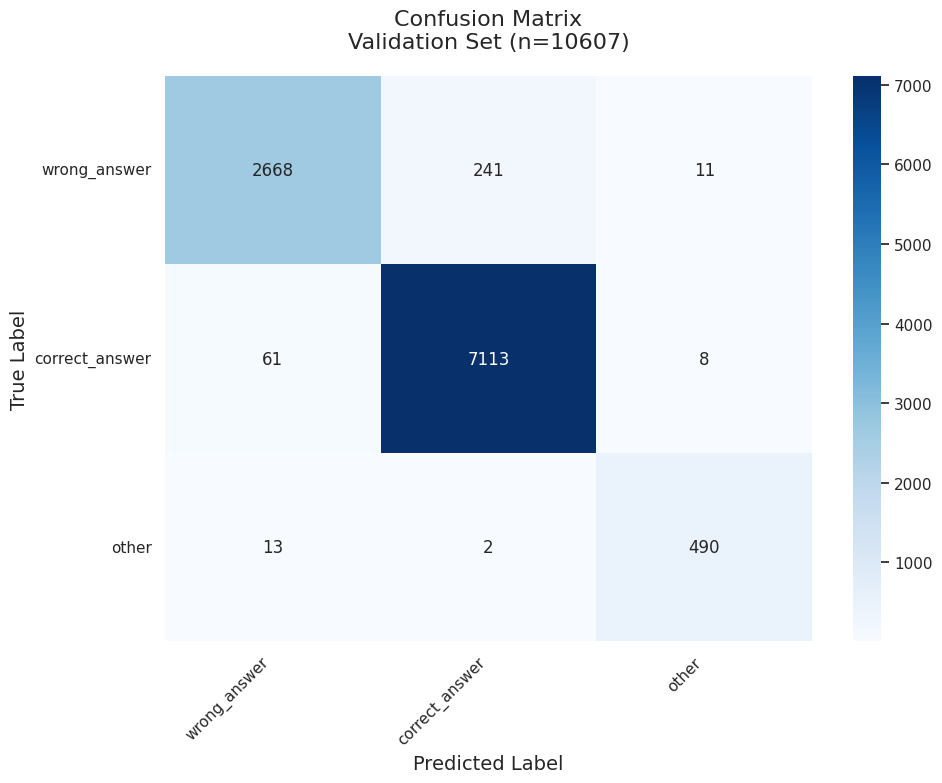


DETAILED CLASSIFICATION REPORT

Per-class metrics:
         Class  Precision  Recall  F1-Score  Support
  wrong_answer      0.973   0.914     0.942     2920
correct_answer      0.967   0.990     0.979     7182
         other      0.963   0.970     0.966      505

------------------------------------------------------------
Overall Accuracy: 0.968
Weighted F1-Score: 0.968

NORMALIZED CONFUSION MATRIX


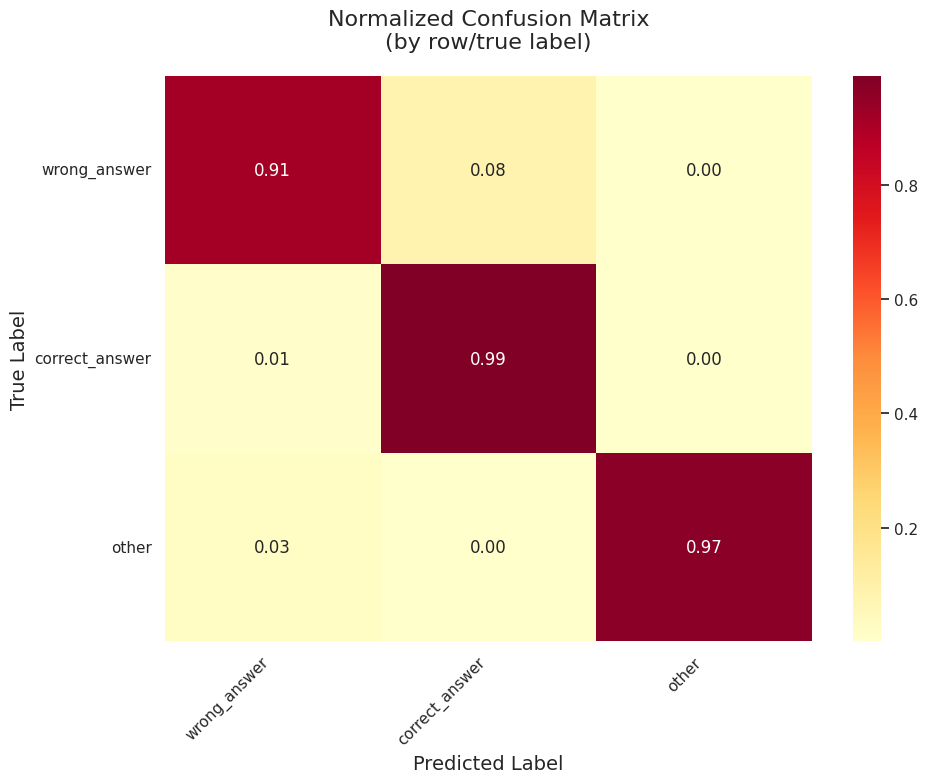


CLASS DISTRIBUTION IN VALIDATION SET
         Class  Count  Percentage
  wrong_answer   2920        27.5
correct_answer   7182        67.7
         other    505         4.8


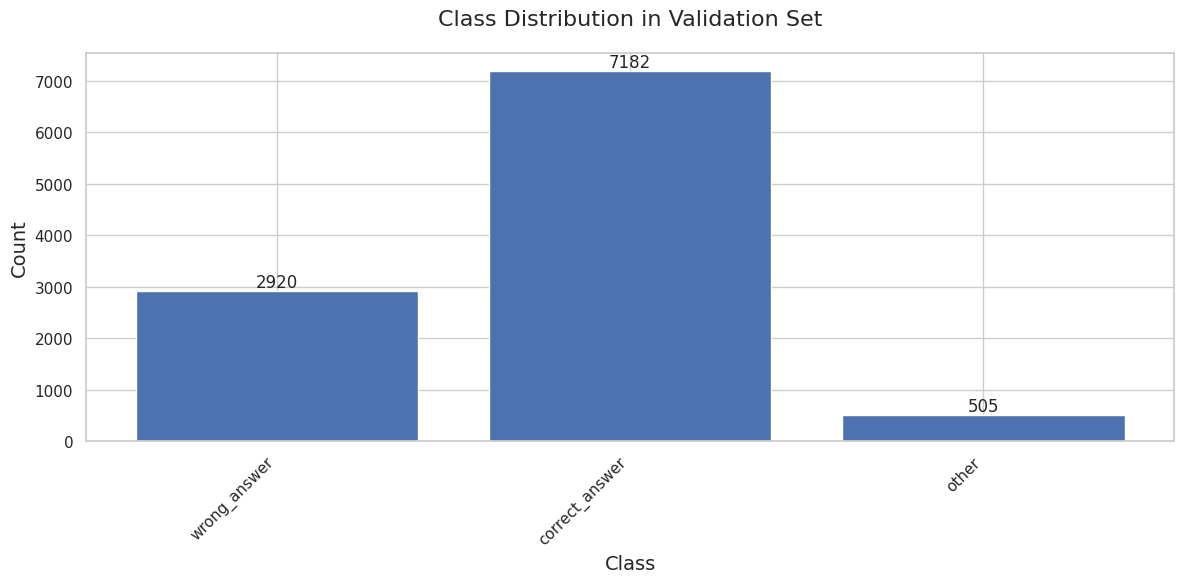


SAVING RESULTS
✓ Confusion matrix saved as 'confusion_matrix.csv'
✓ Detailed classification report saved as 'classification_report.csv'

Analysis complete! Check the visualizations above.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Function to create and display confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """
    Plot a confusion matrix with labels
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)

    plt.title(title, fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm

# Get predictions on validation set
print("Getting predictions on validation set...")
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Get the label names (reverse the label_map)
id_to_label = {v: k for k, v in label_map.items()}
class_names = [id_to_label[i] for i in sorted(id_to_label.keys())]

# Create confusion matrix
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)
cm = plot_confusion_matrix(y_true, y_pred, class_names,
                          title=f'Confusion Matrix\nValidation Set (n={len(y_true)})')

# Calculate and display performance metrics per class
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)

# Calculate metrics per class
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=range(len(class_names))
)

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision.round(3),
    'Recall': recall.round(3),
    'F1-Score': f1.round(3),
    'Support': support
})

print("\nPer-class metrics:")
print(metrics_df.to_string(index=False))

# Overall metrics
print("\n" + "-"*60)
print(f"Overall Accuracy: {accuracy_score(y_true, y_pred):.3f}")
print(f"Weighted F1-Score: {f1_score(y_true, y_pred, average='weighted'):.3f}")

# Create a normalized confusion matrix
print("\n" + "="*60)
print("NORMALIZED CONFUSION MATRIX")
print("="*60)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Normalized Confusion Matrix\n(by row/true label)', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display class distribution
print("\n" + "="*60)
print("CLASS DISTRIBUTION IN VALIDATION SET")
print("="*60)

class_distribution = pd.DataFrame({
    'Class': class_names,
    'Count': np.bincount(y_true, minlength=len(class_names)),
    'Percentage': (np.bincount(y_true, minlength=len(class_names)) / len(y_true) * 100).round(1)
})

print(class_distribution.to_string(index=False))

# Optional: Create a bar chart of class distribution
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_distribution['Count'])
plt.title('Class Distribution in Validation Set', fontsize=16, pad=20)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Optional: Save confusion matrix and metrics to file
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Save confusion matrix as CSV
confusion_df = pd.DataFrame(cm, index=class_names, columns=class_names)
confusion_df.to_csv('confusion_matrix.csv')
print("✓ Confusion matrix saved as 'confusion_matrix.csv'")

# Save detailed metrics as CSV
detailed_metrics = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(detailed_metrics).transpose()
report_df.to_csv('classification_report.csv')
print("✓ Detailed classification report saved as 'classification_report.csv'")

print("\nAnalysis complete! Check the visualizations above.")

## Step 5: Content Adaptation via Bayesian Knowledge Tracing (BKT)

To move beyond static grading, we introduce **Bayesian Knowledge Tracing (BKT)**.

BKT models a student's latent mastery level for each topic and updates it
after every interaction, allowing the system to:
- Track learning progress over time
- Detect struggling students
- Decide when to remediate or advance difficulty

### **Bayesian Knowledge Tracker Design**

The implemented BKT model:
- Uses realistic slip, guess, and learning probabilities
- Penalizes repeated mistakes via forgetting mechanisms
- Adapts parameters dynamically based on performance patterns
- Maintains persistent knowledge states across sessions

### **Knowledge Update Mechanism**

The knowledge update follows Bayesian inference rules:
- Correct answers increase mastery probabilistically
- Incorrect answers reduce mastery
- Consecutive errors trigger additional forgetting penalties

This design ensures realistic and pedagogically sound knowledge evolution.


KNOWLEDGE TRACING SYSTEM INITIALIZATION

📊 BKT Tracker Initialized:
  Initial Knowledge (p_L0): 30%
  Learning Rate (p_T): 10%
  Slip Rate (p_S): 15%
  Guess Rate (p_G): 15%

RUNNING SIMULATIONS

🧑‍🎓 Simulating student_weak on algebra (true mastery: 0.3)
   Completed 15 interactions

🧑‍🎓 Simulating student_avg on geometry (true mastery: 0.5)
   Completed 20 interactions

🧑‍🎓 Simulating student_strong on calculus (true mastery: 0.7)
   Completed 15 interactions

EVALUATING RESULTS
SIMULATION EVALUATION

📈 Adaptation Actions Distribution:
adaptation
Level Up     30
Remediate    13
Stay          7
Name: count, dtype: int64

📊 Mastery Progression Analysis:
  student_weak - algebra: 0.300 → 0.363 (Δ: +0.063)
  student_avg - geometry: 0.300 → 1.000 (Δ: +0.700)
  student_strong - calculus: 0.300 → 1.000 (Δ: +0.700)

🎯 ML Model Performance (simulated):
  Accuracy: 0.860
  F1 Score: 0.896

VISUALIZING KNOWLEDGE TRAJECTORIES


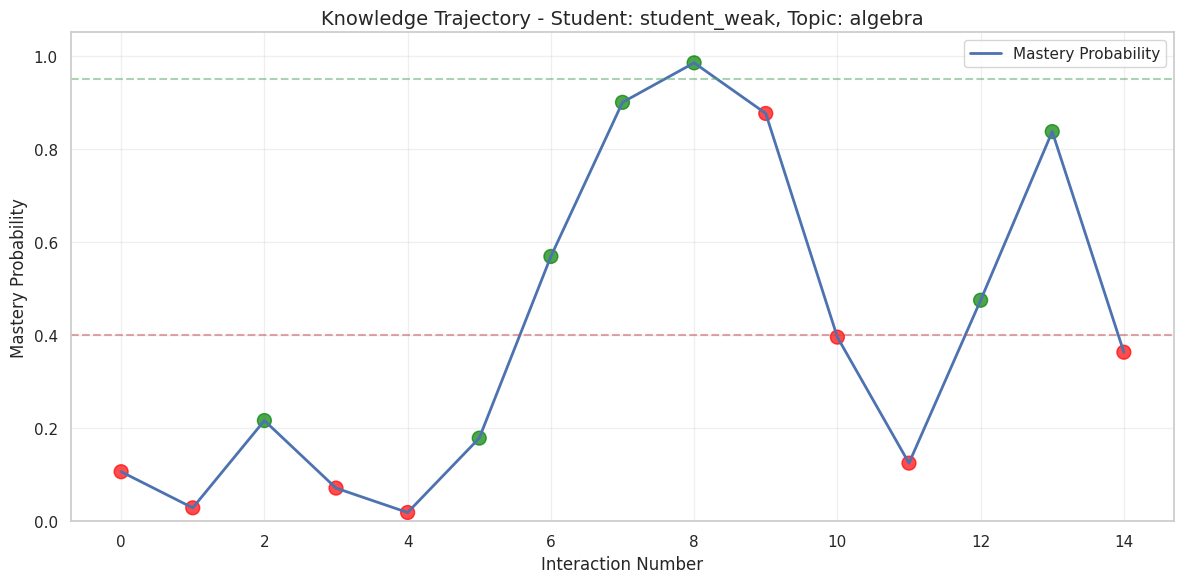

📊 Knowledge Summary for student_weak - algebra:
   Current Mastery: 0.363
   Total Interactions: 15
   Correct Answers: 7
   Incorrect Answers: 8
   Performance Trend: declining


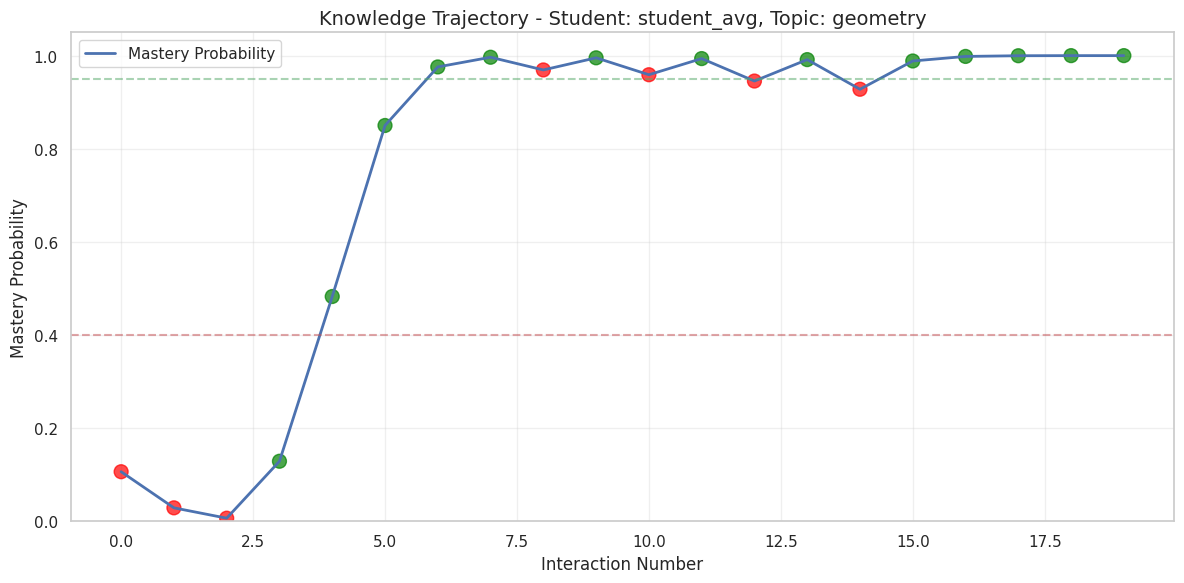

📊 Knowledge Summary for student_avg - geometry:
   Current Mastery: 1.000
   Total Interactions: 20
   Correct Answers: 13
   Incorrect Answers: 7
   Performance Trend: stable


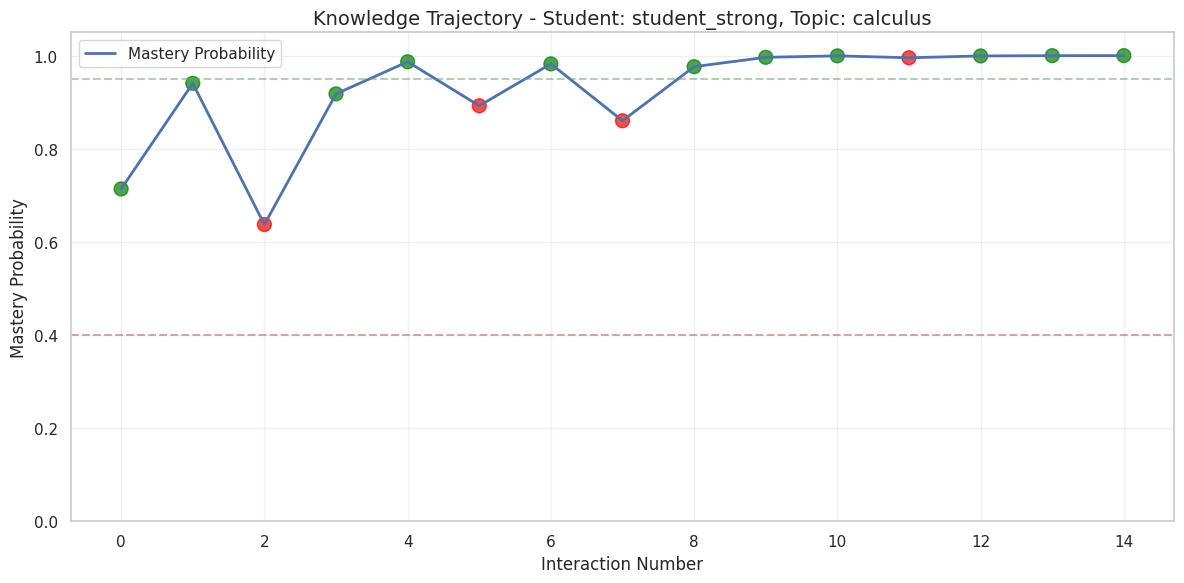

📊 Knowledge Summary for student_strong - calculus:
   Current Mastery: 1.000
   Total Interactions: 15
   Correct Answers: 11
   Incorrect Answers: 4
   Performance Trend: stable

💾 Knowledge states saved to 'kt_states_fixed.pkl'

EXAMPLE USAGE WITH REAL DATA

📋 Example Adaptation Decision:
  student_id: real_student_001
  topic: fractions
  action: Stay
  explanation: Continue with similar difficulty
  next_level: 2
  mastery_probability: 0.714
  is_correct: True
  predicted_correct_prob: 0.65
  performance_trend: insufficient_data
  timestamp: 2026-02-06T18:44:15.074372

SYSTEM READY FOR DEPLOYMENT

The knowledge tracing system is now ready to:
1. Track student knowledge in real-time
2. Adapt question difficulty automatically
3. Provide remediation when needed
4. Level up students when they're ready

GENERATING SAMPLE REPORTS

📋 STUDENT REPORT: student_weak
Topic                Mastery    Status         
--------------------------------------------------
algebra              0.363   

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import pickle
import os
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class BayesianKnowledgeTracker:
    """
    FIXED: Bayesian Knowledge Tracing with realistic parameter values
    that properly respond to incorrect answers.
    """
    def __init__(self, cache_file='kt_states.pkl'):
        # FIXED BKT Parameters - More realistic values
        self.params = {
            'p_L0': 0.3,      # Prior probability of knowing the skill (30%)
            'p_T': 0.1,       # Probability of learning (10% per question) - REDUCED
            'p_S': 0.15,      # Slip: wrong answer despite knowing (15%) - INCREASED
            'p_G': 0.15       # Guess: correct answer without knowing (15%) - REDUCED
        }

        self.cache_file = cache_file

        # Track knowledge state per student per topic
        self.knowledge_state = defaultdict(lambda: defaultdict(lambda: self.params['p_L0']))

        # Track interaction history for analysis
        self.interaction_history = defaultdict(list)

        # Track consecutive correct/incorrect counts for adaptive params
        self.consecutive_counts = defaultdict(lambda: defaultdict(lambda: {'correct': 0, 'incorrect': 0}))

        # Load previous state if exists
        self.load_state()

    def load_state(self):
        """Load previously saved knowledge states."""
        if os.path.exists(self.cache_file):
            try:
                with open(self.cache_file, 'rb') as f:
                    saved_data = pickle.load(f)
                    self.knowledge_state = defaultdict(
                        lambda: defaultdict(lambda: self.params['p_L0']),
                        saved_data.get('knowledge_state', {})
                    )
                    self.interaction_history = defaultdict(
                        list,
                        saved_data.get('interaction_history', {})
                    )
                    self.consecutive_counts = defaultdict(
                        lambda: defaultdict(lambda: {'correct': 0, 'incorrect': 0}),
                        saved_data.get('consecutive_counts', {})
                    )
                logging.info(f"Loaded knowledge states from {self.cache_file}")
            except Exception as e:
                logging.error(f"Error loading state: {e}")

    def save_state(self):
        """Save current knowledge states to disk."""
        try:
            with open(self.cache_file, 'wb') as f:
                pickle.dump({
                    'knowledge_state': dict(self.knowledge_state),
                    'interaction_history': dict(self.interaction_history),
                    'consecutive_counts': dict(self.consecutive_counts)
                }, f)
            logging.info(f"Saved knowledge states to {self.cache_file}")
        except Exception as e:
            logging.error(f"Error saving state: {e}")

    def update_knowledge(self, student_id, topic, is_correct):
        """
        FIXED: Update knowledge with proper regression on wrong answers.

        BKT Update Formula:
        If answer is correct:
            P(L_t | correct) = P(L_t-1) * (1 - p_S) / [P(L_t-1)*(1-p_S) + (1-P(L_t-1))*p_G]
        If answer is wrong:
            P(L_t | wrong) = P(L_t-1) * p_S / [P(L_t-1)*p_S + (1-P(L_t-1))*(1-p_G)]

        Then apply learning (only if correct):
            P(L_t) = P(L_t | obs) + (1 - P(L_t | obs)) * p_T
        """
        p_L = self.knowledge_state[student_id][topic]
        p_S = self.params['p_S']
        p_G = self.params['p_G']
        p_T = self.params['p_T']

        # Update consecutive counts
        if is_correct:
            self.consecutive_counts[student_id][topic]['correct'] += 1
            self.consecutive_counts[student_id][topic]['incorrect'] = 0
        else:
            self.consecutive_counts[student_id][topic]['incorrect'] += 1
            self.consecutive_counts[student_id][topic]['correct'] = 0

        # Get adaptive parameters based on performance pattern
        adaptive_params = self._get_adaptive_params(student_id, topic, is_correct)
        p_S = adaptive_params['p_S']
        p_G = adaptive_params['p_G']
        p_T = adaptive_params['p_T']

        # Update based on observation
        if is_correct:
            # P(L | correct answer)
            numerator = p_L * (1 - p_S)
            denominator = p_L * (1 - p_S) + (1 - p_L) * p_G
        else:
            # P(L | wrong answer)
            numerator = p_L * p_S
            denominator = p_L * p_S + (1 - p_L) * (1 - p_G)

        # Avoid division by zero
        if denominator > 0:
            p_L_given_obs = numerator / denominator
        else:
            p_L_given_obs = p_L

        # FIXED: Only apply learning if answer was correct
        # Wrong answers should NOT increase knowledge
        if is_correct:
            p_L_new = p_L_given_obs + (1 - p_L_given_obs) * p_T
        else:
            # Wrong answer: knowledge decreases, no learning bonus
            p_L_new = p_L_given_obs

            # ADDITIONAL: Apply forgetting penalty for consecutive mistakes
            consecutive_wrong = self.consecutive_counts[student_id][topic]['incorrect']
            if consecutive_wrong >= 2:
                # Stronger penalty for repeated mistakes
                forgetting_rate = 0.05 * min(consecutive_wrong, 5)  # Max 25% penalty
                p_L_new = p_L_new * (1 - forgetting_rate)

        # Clamp between 0 and 1
        p_L_new = max(0.0, min(1.0, p_L_new))

        # Update state
        self.knowledge_state[student_id][topic] = p_L_new

        # Log interaction
        self.interaction_history[student_id].append({
            'timestamp': datetime.now().isoformat(),
            'topic': topic,
            'is_correct': is_correct,
            'p_known_before': p_L,
            'p_known_after': p_L_new,
            'change': p_L_new - p_L,
            'consecutive_correct': self.consecutive_counts[student_id][topic]['correct'],
            'consecutive_incorrect': self.consecutive_counts[student_id][topic]['incorrect'],
            'adaptive_params': adaptive_params
        })

        # Auto-save periodically
        if len(self.interaction_history[student_id]) % 10 == 0:
            self.save_state()

        return p_L_new

    def _get_adaptive_params(self, student_id, topic, is_correct):
        """
        ADAPTIVE: Adjust BKT parameters based on student's performance pattern.
        """
        consecutive_correct = self.consecutive_counts[student_id][topic]['correct']
        consecutive_incorrect = self.consecutive_counts[student_id][topic]['incorrect']
        current_mastery = self.knowledge_state[student_id][topic]

        # Base parameters
        p_S = self.params['p_S']
        p_G = self.params['p_G']
        p_T = self.params['p_T']

        # Adapt slip rate based on mastery level
        # High mastery → lower slip (more reliable)
        # Low mastery → higher slip (inconsistent)
        if current_mastery > 0.8:
            p_S = 0.1  # Very reliable
        elif current_mastery > 0.5:
            p_S = 0.15  # Moderately reliable
        else:
            p_S = 0.25  # Unreliable, many slips

        # Adapt guess rate based on recent performance
        # Consecutive wrong → likely not guessing well
        if consecutive_incorrect >= 3:
            p_G = 0.05  # Unlikely to guess correctly when struggling
        elif consecutive_incorrect >= 1:
            p_G = 0.1
        else:
            p_G = 0.15

        # Adapt learning rate based on pattern
        # Consistent performance → faster learning
        if consecutive_correct >= 3:
            p_T = 0.15  # Learning well
        elif consecutive_incorrect >= 3:
            p_T = 0.05  # Struggling to learn
        else:
            p_T = 0.1  # Normal learning

        return {'p_S': p_S, 'p_G': p_G, 'p_T': p_T}

    def get_mastery_probability(self, student_id, topic):
        """Get current probability that student has mastered the topic."""
        return self.knowledge_state[student_id][topic]

    def predict_correctness(self, student_id, topic):
        """
        Predict probability student will answer next question correctly.
        P(correct) = P(L) * (1 - p_S) + (1 - P(L)) * p_G
        """
        p_L = self.knowledge_state[student_id][topic]

        # Use adaptive parameters
        adaptive_params = self._get_adaptive_params(student_id, topic, True)
        p_S = adaptive_params['p_S']
        p_G = adaptive_params['p_G']

        p_correct = p_L * (1 - p_S) + (1 - p_L) * p_G
        return p_correct

    def is_mastered(self, student_id, topic, threshold=0.95):
        """Check if student has mastered topic."""
        return self.knowledge_state[student_id][topic] >= threshold

    def needs_remediation(self, student_id, topic, threshold=0.4):
        """Check if student needs remediation."""
        return self.knowledge_state[student_id][topic] < threshold

    def get_knowledge_summary(self, student_id):
        """Get summary of student's knowledge across all topics."""
        return dict(self.knowledge_state[student_id])

    def calibrate_difficulty(self, student_id, topic, current_level):
        """Adjust difficulty based on mastery probability."""
        p_mastery = self.get_mastery_probability(student_id, topic)

        if p_mastery > 0.9:
            return min(current_level + 1, 5)
        elif p_mastery < 0.3:
            return max(current_level - 1, 1)
        else:
            return current_level

    def get_performance_trend(self, student_id, topic, last_n=5):
        """
        Analyze recent performance trend.
        Returns: 'improving', 'declining', 'stable'
        """
        history = [h for h in self.interaction_history[student_id] if h['topic'] == topic]

        if len(history) < last_n:
            return 'insufficient_data'

        recent = history[-last_n:]
        changes = [h['change'] for h in recent]
        avg_change = np.mean(changes)

        if avg_change > 0.05:
            return 'improving'
        elif avg_change < -0.05:
            return 'declining'
        else:
            return 'stable'


    def visualize_knowledge_trajectory(self, student_id, topic):
        """Plot knowledge trajectory for a specific student and topic."""
        history = [h for h in self.interaction_history[student_id] if h['topic'] == topic]

        if not history:
            print(f"No history found for student {student_id} on topic {topic}")
            return

        timestamps = [h['timestamp'] for h in history]
        p_known = [h['p_known_after'] for h in history]
        correctness = ['green' if h['is_correct'] else 'red' for h in history]

        plt.figure(figsize=(12, 6))
        plt.plot(range(len(p_known)), p_known, 'b-', linewidth=2, label='Mastery Probability')
        plt.scatter(range(len(p_known)), p_known, c=correctness, s=100, alpha=0.7)

        plt.title(f'Knowledge Trajectory - Student: {student_id}, Topic: {topic}', fontsize=14)
        plt.xlabel('Interaction Number', fontsize=12)
        plt.ylabel('Mastery Probability', fontsize=12)
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Add horizontal lines for thresholds
        plt.axhline(y=0.95, color='g', linestyle='--', alpha=0.5, label='Mastery Threshold (0.95)')
        plt.axhline(y=0.4, color='r', linestyle='--', alpha=0.5, label='Remediation Threshold (0.4)')

        plt.tight_layout()
        plt.show()

        # Print summary
        print(f"📊 Knowledge Summary for {student_id} - {topic}:")
        print(f"   Current Mastery: {p_known[-1]:.3f}")
        print(f"   Total Interactions: {len(history)}")
        print(f"   Correct Answers: {sum(1 for h in history if h['is_correct'])}")
        print(f"   Incorrect Answers: {sum(1 for h in history if not h['is_correct'])}")
        print(f"   Performance Trend: {self.get_performance_trend(student_id, topic)}")




## Step 6: Adapter Between ML Assessment and Knowledge Tracing

This adapter function bridges:
- DistilBERT assessment outputs
- Edit-distance-based answer validation
- Bayesian Knowledge Tracing updates

It produces pedagogical decisions such as:
- Remediation
- Staying at the same level
- Leveling up difficulty


In [ ]:
# ============================================================================
# ADAPTER FUNCTION
# ============================================================================

def get_kt_based_adaptation(student_id, pred, edit_dist, metadata, kt_tracker):
    """
    Adapter between raw student response and BKT engine.
    Returns an action decision dict.

    Args:
        student_id: Unique identifier for student
        pred: Prediction from ML model (0=incorrect, 1=correct)
        edit_dist: Edit distance between student answer and expected
        metadata: Dictionary with 'topic' and 'level' keys
        kt_tracker: Instance of BayesianKnowledgeTracker
    """
    try:
        topic = metadata.get('topic')
        current_level = metadata.get('level', 1)

        if not topic:
            logging.warning("No topic provided in metadata")
            return None

        # 1. Determine correctness
        # You can tune this rule later - more sophisticated logic
        is_correct = (pred == 1) and (edit_dist <= 2)

        # 2. Update knowledge state
        mastery = kt_tracker.update_knowledge(
            student_id=student_id,
            topic=topic,
            is_correct=is_correct
        )

        # 3. Decide pedagogical action based on knowledge state
        if kt_tracker.needs_remediation(student_id, topic, threshold=0.4):
            action = "Remediate"
            explanation = "Student needs remediation (mastery < 0.4)"
        elif kt_tracker.is_mastered(student_id, topic, threshold=0.85):
            action = "Level Up"
            explanation = "Student has mastered the topic (mastery ≥ 0.85)"
        else:
            action = "Stay"
            explanation = "Continue with similar difficulty"

        # 4. Adjust difficulty level
        next_level = kt_tracker.calibrate_difficulty(
            student_id=student_id,
            topic=topic,
            current_level=current_level
        )

        # 5. Get performance prediction
        predicted_correct_prob = kt_tracker.predict_correctness(student_id, topic)

        return {
            "student_id": student_id,
            "topic": topic,
            "action": action,
            "explanation": explanation,
            "next_level": next_level,
            "mastery_probability": round(mastery, 3),
            "is_correct": is_correct,
            "predicted_correct_prob": round(predicted_correct_prob, 3),
            "performance_trend": kt_tracker.get_performance_trend(student_id, topic),
            "timestamp": datetime.now().isoformat()
        }

    except Exception as e:
        logging.error(f"KT adaptation error: {e}")
        return None


## Step 7: Simulation Engine for System Validation

To validate the adaptive system, we simulate different student profiles:
- Weak students
- Average students
- Strong students

The simulator generates realistic interactions and evaluates whether
the BKT model tracks learning trends correctly.


In [ ]:
# ============================================================================
# SIMULATION ENGINE
# ============================================================================

class KnowledgeTracingSimulator:
    """Simulate student interactions for testing and evaluation."""

    def __init__(self, kt_tracker):
        self.kt_tracker = kt_tracker
        self.simulation_results = []

    def simulate_student(self, student_id, topic, num_interactions=20, true_mastery=0.5):
        """
        Simulate a student with given true mastery level.
        Returns simulated interaction history.
        """
        interactions = []

        for i in range(num_interactions):
            # Get current mastery from BKT
            current_bkt_mastery = self.kt_tracker.get_mastery_probability(student_id, topic)

            # Simulate answer: based on true mastery with some noise
            # Real student: P(correct) = mastery*(1-slip) + (1-mastery)*guess
            slip = 0.1  # Even experts make mistakes
            guess = 0.2  # Sometimes guess correctly

            true_correct_prob = true_mastery * (1 - slip) + (1 - true_mastery) * guess
            is_correct_simulated = np.random.random() < true_correct_prob

            # Simulate ML prediction (not perfect)
            # ML accuracy: 90% if we want to simulate good ML model
            ml_accuracy = 0.9
            if np.random.random() < ml_accuracy:
                pred = 1 if is_correct_simulated else 0
            else:
                pred = 0 if is_correct_simulated else 1  # Wrong prediction

            # Simulate edit distance
            if is_correct_simulated:
                edit_dist = np.random.choice([0, 1], p=[0.8, 0.2])  # Mostly perfect matches
            else:
                edit_dist = np.random.choice([2, 3, 4], p=[0.5, 0.3, 0.2])  # Various errors

            # Get adaptation decision
            adaptation = get_kt_based_adaptation(
                student_id=student_id,
                pred=pred,
                edit_dist=edit_dist,
                metadata={'topic': topic, 'level': i % 5 + 1},
                kt_tracker=self.kt_tracker
            )

            interaction = {
                'student_id': student_id,
                'topic': topic,
                'interaction_num': i + 1,
                'true_mastery': true_mastery,
                'simulated_correct': is_correct_simulated,
                'ml_prediction': pred,
                'edit_distance': edit_dist,
                'adaptation': adaptation,
                'bkt_mastery_before': current_bkt_mastery,
                'bkt_mastery_after': adaptation['mastery_probability'] if adaptation else None
            }

            interactions.append(interaction)

            # Update true mastery (simulate learning)
            if is_correct_simulated:
                true_mastery = min(1.0, true_mastery + 0.05 * (1 - true_mastery))
            else:
                true_mastery = max(0.0, true_mastery - 0.02)

        self.simulation_results.extend(interactions)
        return interactions

    def evaluate_simulation(self):
        """Evaluate the simulation results."""
        if not self.simulation_results:
            print("No simulation results to evaluate")
            return

        df = pd.DataFrame(self.simulation_results)

        # Calculate metrics
        print("="*70)
        print("SIMULATION EVALUATION")
        print("="*70)

        # 1. Adaptation actions distribution
        actions = df['adaptation'].apply(lambda x: x['action'] if x else 'None')
        print("\n📈 Adaptation Actions Distribution:")
        print(actions.value_counts())

        # 2. Mastery progression
        print("\n📊 Mastery Progression Analysis:")
        student_topics = df[['student_id', 'topic']].drop_duplicates()

        for _, row in student_topics.iterrows():
            student_data = df[(df['student_id'] == row['student_id']) &
                             (df['topic'] == row['topic'])]
            if len(student_data) > 0:
                initial_mastery = student_data.iloc[0]['bkt_mastery_before']
                final_mastery = student_data.iloc[-1]['bkt_mastery_after']
                print(f"  {row['student_id']} - {row['topic']}: "
                      f"{initial_mastery:.3f} → {final_mastery:.3f} "
                      f"(Δ: {final_mastery - initial_mastery:+.3f})")

        # 3. Accuracy metrics
        if 'simulated_correct' in df.columns and 'ml_prediction' in df.columns:
            ml_accuracy = accuracy_score(df['simulated_correct'], df['ml_prediction'])
            ml_f1 = f1_score(df['simulated_correct'], df['ml_prediction'])
            print(f"\n🎯 ML Model Performance (simulated):")
            print(f"  Accuracy: {ml_accuracy:.3f}")
            print(f"  F1 Score: {ml_f1:.3f}")

        return df

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function."""
    print("="*70)
    print("KNOWLEDGE TRACING SYSTEM INITIALIZATION")
    print("="*70)

    # 1. Initialize BKT Tracker
    kt_tracker = BayesianKnowledgeTracker(cache_file='kt_states_fixed.pkl')

    print("\n📊 BKT Tracker Initialized:")
    print(f"  Initial Knowledge (p_L0): {kt_tracker.params['p_L0']*100:.0f}%")
    print(f"  Learning Rate (p_T): {kt_tracker.params['p_T']*100:.0f}%")
    print(f"  Slip Rate (p_S): {kt_tracker.params['p_S']*100:.0f}%")
    print(f"  Guess Rate (p_G): {kt_tracker.params['p_G']*100:.0f}%")

    # 2. Initialize Simulator
    simulator = KnowledgeTracingSimulator(kt_tracker)

    # 3. Run Simulations for Different Student Profiles
    print("\n" + "="*70)
    print("RUNNING SIMULATIONS")
    print("="*70)

    # Simulate different student types
    student_profiles = [
        ('student_weak', 'algebra', 0.3, 15),    # Weak student
        ('student_avg', 'geometry', 0.5, 20),     # Average student
        ('student_strong', 'calculus', 0.7, 15),  # Strong student
    ]

    for student_id, topic, true_mastery, num_interactions in student_profiles:
        print(f"\n🧑‍🎓 Simulating {student_id} on {topic} (true mastery: {true_mastery})")
        interactions = simulator.simulate_student(
            student_id=student_id,
            topic=topic,
            num_interactions=num_interactions,
            true_mastery=true_mastery
        )
        print(f"   Completed {len(interactions)} interactions")

    # 4. Evaluate Simulation Results
    print("\n" + "="*70)
    print("EVALUATING RESULTS")
    print("="*70)

    results_df = simulator.evaluate_simulation()

    # 5. Visualize Knowledge Trajectories
    print("\n" + "="*70)
    print("VISUALIZING KNOWLEDGE TRAJECTORIES")
    print("="*70)

    for student_id, topic, _, _ in student_profiles:
        kt_tracker.visualize_knowledge_trajectory(student_id, topic)

    # 6. Save Final State
    kt_tracker.save_state()
    print(f"\n💾 Knowledge states saved to '{kt_tracker.cache_file}'")

    # 7. Example of Real Usage
    print("\n" + "="*70)
    print("EXAMPLE USAGE WITH REAL DATA")
    print("="*70)

    # Example: Process a real student response
    example_adaptation = get_kt_based_adaptation(
        student_id="real_student_001",
        pred=1,  # ML model predicts correct
        edit_dist=1,  # Small edit distance
        metadata={'topic': 'fractions', 'level': 2},
        kt_tracker=kt_tracker
    )

    if example_adaptation:
        print("\n📋 Example Adaptation Decision:")
        for key, value in example_adaptation.items():
            print(f"  {key}: {value}")

    print("\n" + "="*70)
    print("SYSTEM READY FOR DEPLOYMENT")
    print("="*70)
    print("\nThe knowledge tracing system is now ready to:")
    print("1. Track student knowledge in real-time")
    print("2. Adapt question difficulty automatically")
    print("3. Provide remediation when needed")
    print("4. Level up students when they're ready")

    return kt_tracker, simulator, results_df

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def get_student_report(kt_tracker, student_id):
    """Generate a comprehensive report for a student."""
    knowledge_summary = kt_tracker.get_knowledge_summary(student_id)

    print(f"\n📋 STUDENT REPORT: {student_id}")
    print("="*50)

    if not knowledge_summary:
        print("No data available for this student.")
        return

    print(f"{'Topic':<20} {'Mastery':<10} {'Status':<15}")
    print("-"*50)

    for topic, mastery in knowledge_summary.items():
        if mastery >= 0.85:
            status = "✅ Mastered"
        elif mastery >= 0.6:
            status = "📈 Progressing"
        elif mastery >= 0.4:
            status = "⚠️ Needs Practice"
        else:
            status = "🔴 Needs Remediation"

        print(f"{topic:<20} {mastery:<10.3f} {status:<15}")

    # Get overall statistics
    total_topics = len(knowledge_summary)
    mastered_topics = sum(1 for m in knowledge_summary.values() if m >= 0.85)
    avg_mastery = np.mean(list(knowledge_summary.values()))

    print("\n📊 Overall Statistics:")
    print(f"  Total Topics: {total_topics}")
    print(f"  Mastered Topics: {mastered_topics} ({mastered_topics/total_topics*100:.1f}%)")
    print(f"  Average Mastery: {avg_mastery:.3f}")

def export_knowledge_data(kt_tracker, filename='knowledge_data.csv'):
    """Export all knowledge data to CSV for analysis."""
    all_data = []

    for student_id, topics in kt_tracker.knowledge_state.items():
        for topic, mastery in topics.items():
            all_data.append({
                'student_id': student_id,
                'topic': topic,
                'mastery': mastery,
                'total_interactions': len([h for h in kt_tracker.interaction_history.get(student_id, [])
                                         if h['topic'] == topic]),
                'last_updated': datetime.now().isoformat()
            })

    if all_data:
        df = pd.DataFrame(all_data)
        df.to_csv(filename, index=False)
        print(f"📤 Knowledge data exported to '{filename}'")
        return df
    else:
        print("No knowledge data to export.")
        return None

# ============================================================================
# EXECUTE THE SYSTEM
# ============================================================================

if __name__ == "__main__":
    # Run the complete system
    kt_tracker, simulator, results_df = main()

    # Optional: Generate reports
    print("\n" + "="*70)
    print("GENERATING SAMPLE REPORTS")
    print("="*70)

    # Generate report for simulated students
    for student_id in ['student_weak', 'student_avg', 'student_strong']:
        get_student_report(kt_tracker, student_id)

    # Export data
    export_knowledge_data(kt_tracker)

## Step 9: Interactive Student Assessment

In this interactive phase:
- The user answers randomly sampled questions
- DistilBERT evaluates the answers
- Performance metrics are computed in real time

This simulates real deployment conditions.


In [ ]:
import os

for root, dirs, files in os.walk(".", topdown=True):
    if "config.json" in files:
        print(root)


./t5-ammor-qg
./t5-ammor-qg/checkpoint-29830
./t5-ammor-qg/checkpoint-29000
./t5_ammore_model/best_model
./results/checkpoint-10608
./results/checkpoint-2652
./results/checkpoint-7956
./results/checkpoint-13260
./results/checkpoint-5304
./distilbert_assessment_model


In [ ]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "./distilbert_assessment_model"
)

model.to(device)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# import random
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# -----------------------------
# CONFIG
# -----------------------------
NUM_QUESTIONS = 5
MAX_LENGTH = 64
RANDOM_SEED = 42

random.seed(RANDOM_SEED)

model.eval()
model.to(device)

id_to_label = {v: k for k, v in label_map.items()}

# -----------------------------
# 1. Sample data
# -----------------------------
sampled = processed_data.sample(
    n=NUM_QUESTIONS,
    random_state=RANDOM_SEED
).reset_index(drop=True)

# Ground truth kept separately
ground_truth = sampled[["label", "human_label"]].copy()

# Only questions (NO answers, NO labels)
question_data = sampled[["question"]].copy()

# -----------------------------
# 2. Interactive Evaluation
# -----------------------------
results = []

print("=" * 70)
print("INTERACTIVE STUDENT ASSESSMENT")
print("=" * 70)

for i, row in question_data.iterrows():
    question = row["question"]

    print(f"\n🧮 Question {i+1}")
    print("-" * 70)
    print(question)

    # 👤 Ask the student
    student_answer = input("\n✍️ Your answer: ")

    combined_text = student_answer + " [SEP] " + question

    encoding = tokenizer(
        combined_text,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(
            input_ids=encoding["input_ids"].to(device),
            attention_mask=encoding["attention_mask"].to(device)
        )
        pred_label = outputs.logits.argmax(dim=1).item()

    pred_label_name = id_to_label[pred_label]
    true_label = ground_truth.loc[i, "label"]
    true_label_name = ground_truth.loc[i, "human_label"]

    correct = pred_label == true_label

    print(f"\n🧠 Model Evaluation : {pred_label_name}")
    print(f"📌 Ground Truth    : {true_label_name}")
    print(f"✅ Correct         : {'YES' if correct else 'NO'}")

    results.append({
        "true_label": true_label,
        "pred_label": pred_label,
        "correct": correct
    })

# -----------------------------
# 3. Summary
# -----------------------------
results_df = pd.DataFrame(results)

accuracy = accuracy_score(results_df["true_label"], results_df["pred_label"])
f1 = f1_score(results_df["true_label"], results_df["pred_label"], average="weighted")

print("\n" + "=" * 70)
print("FINAL STUDENT SUMMARY")
print("=" * 70)
print(f"Accuracy    : {accuracy:.3f}")
print(f"Weighted F1 : {f1:.3f}")


INTERACTIVE STUDENT ASSESSMENT

🧮 Question 1
----------------------------------------------------------------------
123.521 rounded off to the nearest whole number is __________



✍️ Your answer:  124



🧠 Model Evaluation : other
📌 Ground Truth    : wrong_answer
✅ Correct         : NO

🧮 Question 2
----------------------------------------------------------------------
Choose the correct coordinates that satisfies the linear function y = 5x - 2.
A. (0, -2)
B. (1, -7)
C. (3, 12)
D. (2, 10)



✍️ Your answer:  A



🧠 Model Evaluation : correct_answer
📌 Ground Truth    : correct_answer
✅ Correct         : YES

🧮 Question 3
----------------------------------------------------------------------
499,998 ___ 500,000



✍️ Your answer:  <



🧠 Model Evaluation : correct_answer
📌 Ground Truth    : correct_answer
✅ Correct         : YES

🧮 Question 4
----------------------------------------------------------------------
189.073 rounded off to the nearest tenths place is __________



✍️ Your answer:  189.1



🧠 Model Evaluation : wrong_answer
📌 Ground Truth    : correct_answer
✅ Correct         : NO

🧮 Question 5
----------------------------------------------------------------------
Change the number to scientific form. Halfway there, *5 questions* left.

12000 can be written as
A) 120 × 100
B) 1200 × 10
C) 1.2 × 10⁴
D) 0.12 × 10⁵



✍️ Your answer:  C



🧠 Model Evaluation : correct_answer
📌 Ground Truth    : correct_answer
✅ Correct         : YES

FINAL STUDENT SUMMARY
Accuracy    : 0.600
Weighted F1 : 0.686


## Step 10: Integrated Assessment and Knowledge Tracing

This final step integrates:
- DistilBERT answer evaluation
- Bayesian Knowledge Tracing updates
- Visualization of mastery progression

The result is a fully adaptive tutoring loop that continuously learns
from student interactions.


INTERACTIVE STUDENT ASSESSMENT (DistilBERT → BKT)

🧮 Question 1
------------------------------------------------------------
123.521 rounded off to the nearest whole number is __________



✍️ Your answer:  124



🧠 Model Evaluation : other
📌 Ground Truth    : wrong_answer
✅ Correct         : NO
📈 Mastery        : 0.32

🧮 Question 2
------------------------------------------------------------
Choose the correct coordinates that satisfies the linear function y = 5x - 2.
A. (0, -2)
B. (1, -7)
C. (3, 12)
D. (2, 10)



✍️ Your answer:  a



🧠 Model Evaluation : correct_answer
📌 Ground Truth    : correct_answer
✅ Correct         : YES
📈 Mastery        : 0.78

🧮 Question 3
------------------------------------------------------------
499,998 ___ 500,000



✍️ Your answer:  <



🧠 Model Evaluation : correct_answer
📌 Ground Truth    : correct_answer
✅ Correct         : YES
📈 Mastery        : 0.96

🧮 Question 4
------------------------------------------------------------
189.073 rounded off to the nearest tenths place is __________



✍️ Your answer:  189.1



🧠 Model Evaluation : wrong_answer
📌 Ground Truth    : correct_answer
✅ Correct         : NO
📈 Mastery        : 0.82

🧮 Question 5
------------------------------------------------------------
Change the number to scientific form. Halfway there, *5 questions* left.

12000 can be written as
A) 120 × 100
B) 1200 × 10
C) 1.2 × 10⁴
D) 0.12 × 10⁵



✍️ Your answer:  c



🧠 Model Evaluation : correct_answer
📌 Ground Truth    : correct_answer
✅ Correct         : YES
📈 Mastery        : 0.97

MODEL PERFORMANCE (ON YOUR ANSWERS)
Accuracy    : 0.600
Weighted F1 : 0.686


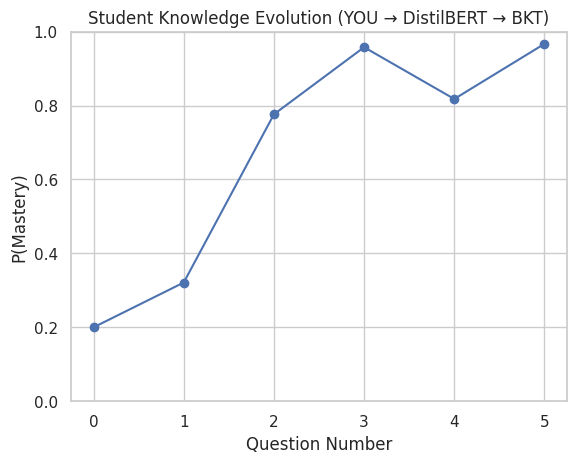

In [ ]:
import random
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# -----------------------------
# CONFIG
# -----------------------------
NUM_QUESTIONS = 5
MAX_LENGTH = 64
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

model.eval()
model.to(device)

id_to_label = {v: k for k, v in label_map.items()}

# -----------------------------
# BKT PARAMETERS
# -----------------------------
p_init = 0.2
p_learn = 0.3
p_guess = 0.2
p_slip = 0.1

def bkt_update(p_mastery, correct):
    if correct:
        num = p_mastery * (1 - p_slip)
        den = num + (1 - p_mastery) * p_guess
    else:
        num = p_mastery * p_slip
        den = num + (1 - p_mastery) * (1 - p_guess)

    posterior = num / den
    return posterior + (1 - posterior) * p_learn

# -----------------------------
# 1. Sample questions
# -----------------------------
sampled = processed_data.sample(
    n=NUM_QUESTIONS,
    random_state=RANDOM_SEED
).reset_index(drop=True)

# Ground truth (hidden from user & model)
ground_truth = sampled[["label", "human_label"]].copy()

question_data = sampled[["question"]].copy()

# -----------------------------
# 2. INTERACTIVE DistilBERT → BKT
# -----------------------------
results = []
mastery = p_init
mastery_history = [mastery]

print("=" * 70)
print("INTERACTIVE STUDENT ASSESSMENT (DistilBERT → BKT)")
print("=" * 70)

for i, row in question_data.iterrows():
    question = row["question"]

    print(f"\n🧮 Question {i+1}")
    print("-" * 60)
    print(question)

    # 👤 YOU answer
    student_answer = input("\n✍️ Your answer: ")

    combined_text = student_answer + " [SEP] " + question

    encoding = tokenizer(
        combined_text,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

    # ---- DistilBERT inference ----
    with torch.no_grad():
        outputs = model(
            input_ids=encoding["input_ids"].to(device),
            attention_mask=encoding["attention_mask"].to(device)
        )
        pred_label = outputs.logits.argmax(dim=1).item()

    true_label = ground_truth.loc[i, "label"]
    true_label_name = ground_truth.loc[i, "human_label"]

    correct = int(pred_label == true_label)

    # ---- BKT update ----
    mastery = bkt_update(mastery, correct)
    mastery_history.append(mastery)

    print(f"\n🧠 Model Evaluation : {id_to_label[pred_label]}")
    print(f"📌 Ground Truth    : {true_label_name}")
    print(f"✅ Correct         : {'YES' if correct else 'NO'}")
    print(f"📈 Mastery        : {mastery:.2f}")

    results.append({
        "true_label": true_label,
        "pred_label": pred_label,
        "correct": correct
    })

# -----------------------------
# 3. DistilBERT Metrics
# -----------------------------
results_df = pd.DataFrame(results)

accuracy = accuracy_score(results_df["true_label"], results_df["pred_label"])
f1 = f1_score(results_df["true_label"], results_df["pred_label"], average="weighted")

print("\n" + "=" * 70)
print("MODEL PERFORMANCE (ON YOUR ANSWERS)")
print("=" * 70)
print(f"Accuracy    : {accuracy:.3f}")
print(f"Weighted F1 : {f1:.3f}")

# -----------------------------
# 4. BKT Evolution Graph
# -----------------------------
plt.figure()
plt.plot(range(len(mastery_history)), mastery_history, marker='o')
plt.xlabel("Question Number")
plt.ylabel("P(Mastery)")
plt.title("Student Knowledge Evolution (YOU → DistilBERT → BKT)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()
